In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import os
import numpy as np
import pandas as pd
import proplot as pplt
import matplotlib.pyplot as plt
import pickle
import glob
import tensorflow as tf
import sklearn.metrics as skm
import uncertainty_toolbox as uct
import warnings
from timeit import default_timer as timer
from tqdm import tqdm

warnings.filterwarnings("ignore")

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from gnn_uq.load_data import load_data
from gnn_uq.gnn_model import gnn, nll, RegressionUQSpace
from gnn_uq.result import NLL, cNLL, miscal_area, sort_best_RE, calibrate
from gnn_uq.result import combine_result, conf_level

NAME = ['Lipo', 'ESOL', 'FreeSolv', "QM7"]
UNIT = [r'log D', r'log mol/L', r'kcal/mol', r'kcal/mol']

COLOR = []
cycle = pplt.Cycle('ggplot')
cycle2 = pplt.Cycle('Dark2')
for c in cycle:
    COLOR.append(c['color'])
for c in cycle2:
    COLOR.append(c['color'])

pplt.rc.cycle = 'ggplot'

### Metric-based Benchmark for UQ

In [8]:
with open("../result/val_test_result.pickle", "rb") as handle:
    result = pickle.load(handle)
    
with open("../result/val_test_result_random.pickle", "rb") as handle:
    result_random = pickle.load(handle)
    
def benchmark_result(dataset='Delaney', estimator='MPNN Ensemble'):
    benchmark = pd.read_csv('../data/benchmark_result.csv')
    benchmark = benchmark[
        (benchmark['Data Set'] == dataset) &
        (benchmark['Estimator'] == estimator) &
        (benchmark['Split'] == 'Random Split')
    ]
    return benchmark

In [10]:
our_nll = np.zeros((4, 8))
our_cnll = np.zeros((4, 8))
our_ma = np.zeros((4, 8))
our_sp = np.zeros((4, 8))

random_nll = np.zeros((4, 8))
random_cnll = np.zeros((4, 8))
random_ma = np.zeros((4, 8))
random_sp = np.zeros((4, 8))

ref_nll = np.zeros((4, 8))
ref_cnll = np.zeros((4, 8))
ref_ma = np.zeros((4, 8))
ref_sp = np.zeros((4, 8))

our_nll[0], our_cnll[0], our_ma[0], our_sp[0] = combine_result(result, dataset="lipo", SPLIT_TYPE = "523")
our_nll[1], our_cnll[1], our_ma[1], our_sp[1] = combine_result(result, dataset="delaney", SPLIT_TYPE = "523")
our_nll[2], our_cnll[2], our_ma[2], our_sp[2] = combine_result(result, dataset="freesolv", SPLIT_TYPE = "523")
our_nll[3], our_cnll[3], our_ma[3], our_sp[3] = combine_result(result, dataset="qm7", SPLIT_TYPE = "523")

random_nll[0], random_cnll[0], random_ma[0], random_sp[0] = combine_result(result_random, dataset="lipo", SPLIT_TYPE = "523")
random_nll[1], random_cnll[1], random_ma[1], random_sp[1] = combine_result(result_random, dataset="delaney", SPLIT_TYPE = "523")
random_nll[2], random_cnll[2], random_ma[2], random_sp[2] = combine_result(result_random, dataset="freesolv", SPLIT_TYPE = "523")
random_nll[3], random_cnll[3], random_ma[3], random_sp[3] = combine_result(result_random, dataset="qm7", SPLIT_TYPE = "523")

ref_nll[3] = benchmark_result(dataset='QM7', estimator='MPNN Ensemble')['Average NLL']
ref_nll[2] = benchmark_result(dataset='Delaney', estimator='MPNN Ensemble')['Average NLL']
ref_nll[1] = benchmark_result(dataset='freesolv', estimator='MPNN Ensemble')['Average NLL']
ref_nll[0] = benchmark_result(dataset='lipo', estimator='MPNN Ensemble')['Average NLL']

ref_cnll[3] = benchmark_result(dataset='QM7', estimator='MPNN Ensemble')['Average Calibrated NLL']
ref_cnll[2] = benchmark_result(dataset='Delaney', estimator='MPNN Ensemble')['Average Calibrated NLL']
ref_cnll[1] = benchmark_result(dataset='freesolv', estimator='MPNN Ensemble')['Average Calibrated NLL']
ref_cnll[0] = benchmark_result(dataset='lipo', estimator='MPNN Ensemble')['Average Calibrated NLL']

ref_ma[3] = benchmark_result(dataset='QM7', estimator='MPNN Ensemble')['Miscalibration Area']
ref_ma[2] = benchmark_result(dataset='Delaney', estimator='MPNN Ensemble')['Miscalibration Area']
ref_ma[1] = benchmark_result(dataset='freesolv', estimator='MPNN Ensemble')['Miscalibration Area']
ref_ma[0] = benchmark_result(dataset='lipo', estimator='MPNN Ensemble')['Miscalibration Area']


ref_sp[3] = benchmark_result(dataset='QM7', estimator='MPNN Ensemble')["Spearman's Coefficient"]
ref_sp[2] = benchmark_result(dataset='Delaney', estimator='MPNN Ensemble')["Spearman's Coefficient"]
ref_sp[1] = benchmark_result(dataset='freesolv', estimator='MPNN Ensemble')["Spearman's Coefficient"]
ref_sp[0] = benchmark_result(dataset='lipo', estimator='MPNN Ensemble')["Spearman's Coefficient"]

print(f"# Results combined ...")

# Results combined ...


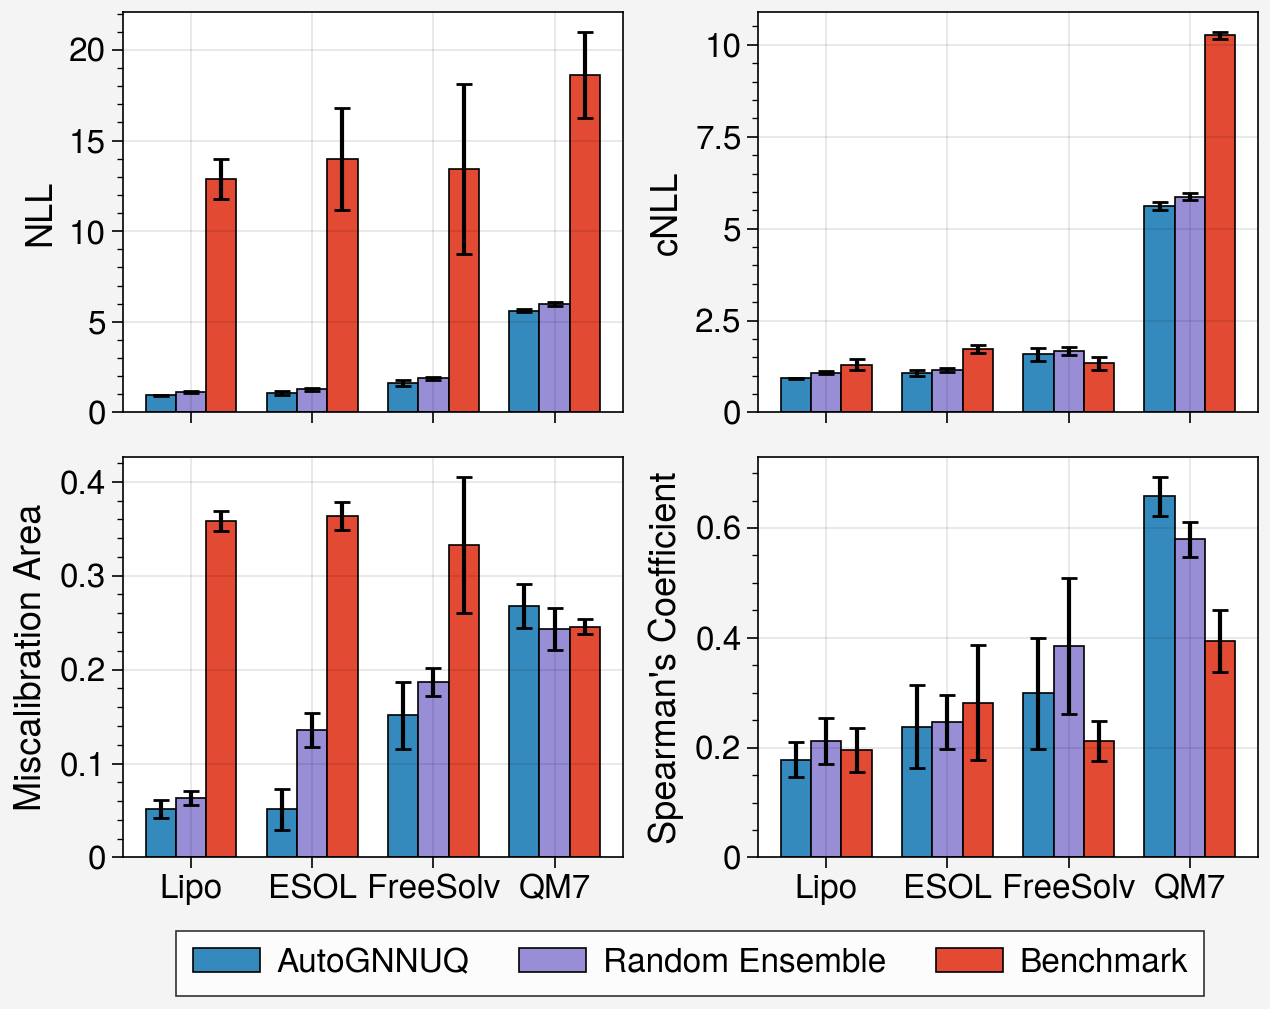

In [11]:
fig, ax = pplt.subplots(nrows=2, ncols=2, sharey=False, refwidth=2.5, refheight=2)

xx = np.arange(4) * 4

our_d = [our_nll, our_cnll, our_ma, our_sp]
rad_d = [random_nll, random_cnll, random_ma, random_sp]
ref_d = [ref_nll, ref_cnll, ref_ma, ref_sp]

ylabels = ["NLL", "cNLL", "Miscalibration Area", "Spearman's Coefficient"]

for i in range(4):
    d1 = our_d[i]
    d2 = rad_d[i]
    d3 = ref_d[i]
    
    d1_mean = np.mean(d1, axis=1)
    d2_mean = np.mean(d2, axis=1)
    d3_mean = np.mean(d3, axis=1)
    
    diff = np.divide(d1_mean - d3_mean, d3_mean) * 100
    
    if i == 0:
        ax[i].bar(xx-1, np.mean(d1, axis=1), yerr=np.std(d1, axis=1), width=.25, label='AutoGNNUQ', edgecolor='k', c=COLOR[1])
        ax[i].bar(xx, np.mean(d2, axis=1), yerr=np.std(d2, axis=1), width=.25, label='Random Ensemble', edgecolor='k', c=COLOR[2])
        ax[i].bar(xx+1, np.mean(d3, axis=1), yerr=np.std(d3, axis=1), width=.25, label='Benchmark', edgecolor='k', c=COLOR[0])
    else:
        ax[i].bar(xx-1, np.mean(d1, axis=1), yerr=np.std(d1, axis=1), width=.25, edgecolor='k', c=COLOR[1])
        ax[i].bar(xx, np.mean(d2, axis=1), yerr=np.std(d2, axis=1), width=.25, edgecolor='k', c=COLOR[2])
        ax[i].bar(xx+1, np.mean(d3, axis=1), yerr=np.std(d3, axis=1), width=.25, edgecolor='k', c=COLOR[0])
    ax[i].set_xticks(xx)
    ax[i].set_xticklabels(NAME[:4])
    ax[i].xaxis.set_minor_locator(plt.NullLocator())
    ax[i].format(ylabel=ylabels[i], xticklabelsize=12, yticklabelsize=12, xlabelsize=13, ylabelsize=13)


fig.legend(loc='b', prop={'size': 12})

plt.savefig('../result/fig/metrics.svg', dpi=300, bbox_inches='tight')


### Uncertainty vs Error

# seed 0 uncertainty vs err ...
# seed 1 uncertainty vs err ...
# seed 2 uncertainty vs err ...
# seed 3 uncertainty vs err ...
# seed 4 uncertainty vs err ...
# seed 5 uncertainty vs err ...
# seed 6 uncertainty vs err ...
# seed 7 uncertainty vs err ...
[[[0.03412698 0.22380952 0.74206349]
  [0.04424779 0.20943953 0.74631268]
  [0.02590674 0.06217617 0.9119171 ]
  [0.04441191 0.04978038 0.90580771]]

 [[0.02857143 0.21507937 0.75634921]
  [0.01179941 0.18289086 0.80530973]
  [0.03626943 0.07772021 0.88601036]
  [0.04148365 0.0624695  0.89604685]]

 [[0.03809524 0.21111111 0.75079365]
  [0.04424779 0.25663717 0.69911504]
  [0.02072539 0.09326425 0.88601036]
  [0.03806735 0.06051733 0.90141532]]

 [[0.03174603 0.20793651 0.76031746]
  [0.03539823 0.19174041 0.77286136]
  [0.05181347 0.15025907 0.79792746]
  [0.02928258 0.0522206  0.91849683]]

 [[0.03650794 0.21349206 0.75      ]
  [0.04129794 0.21533923 0.74336283]
  [0.05181347 0.12953368 0.81865285]
  [0.04197169 0.05173255 0.906295

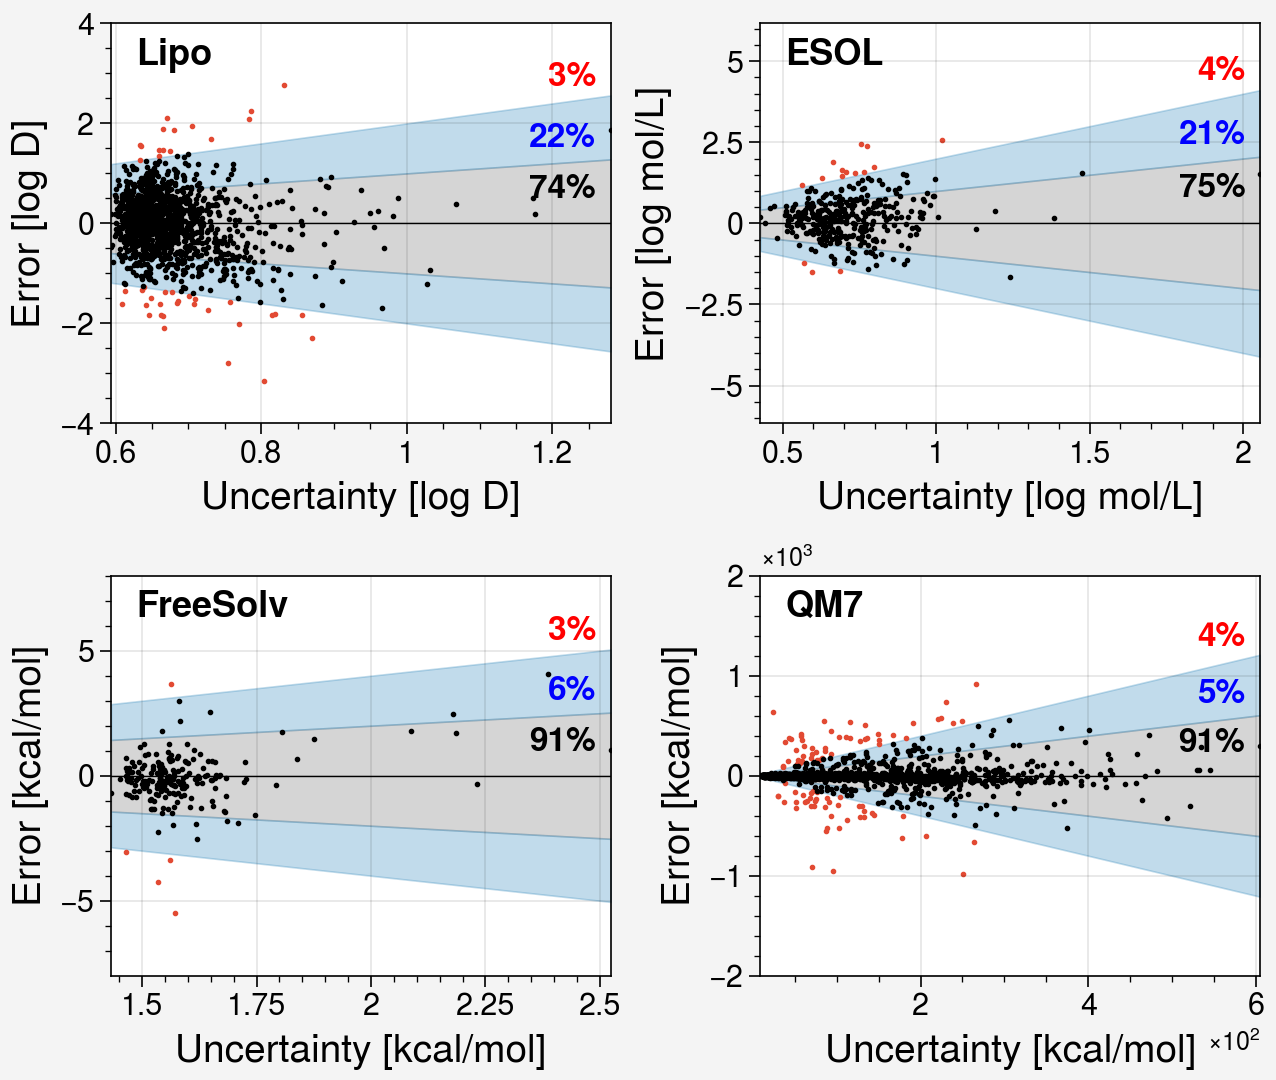

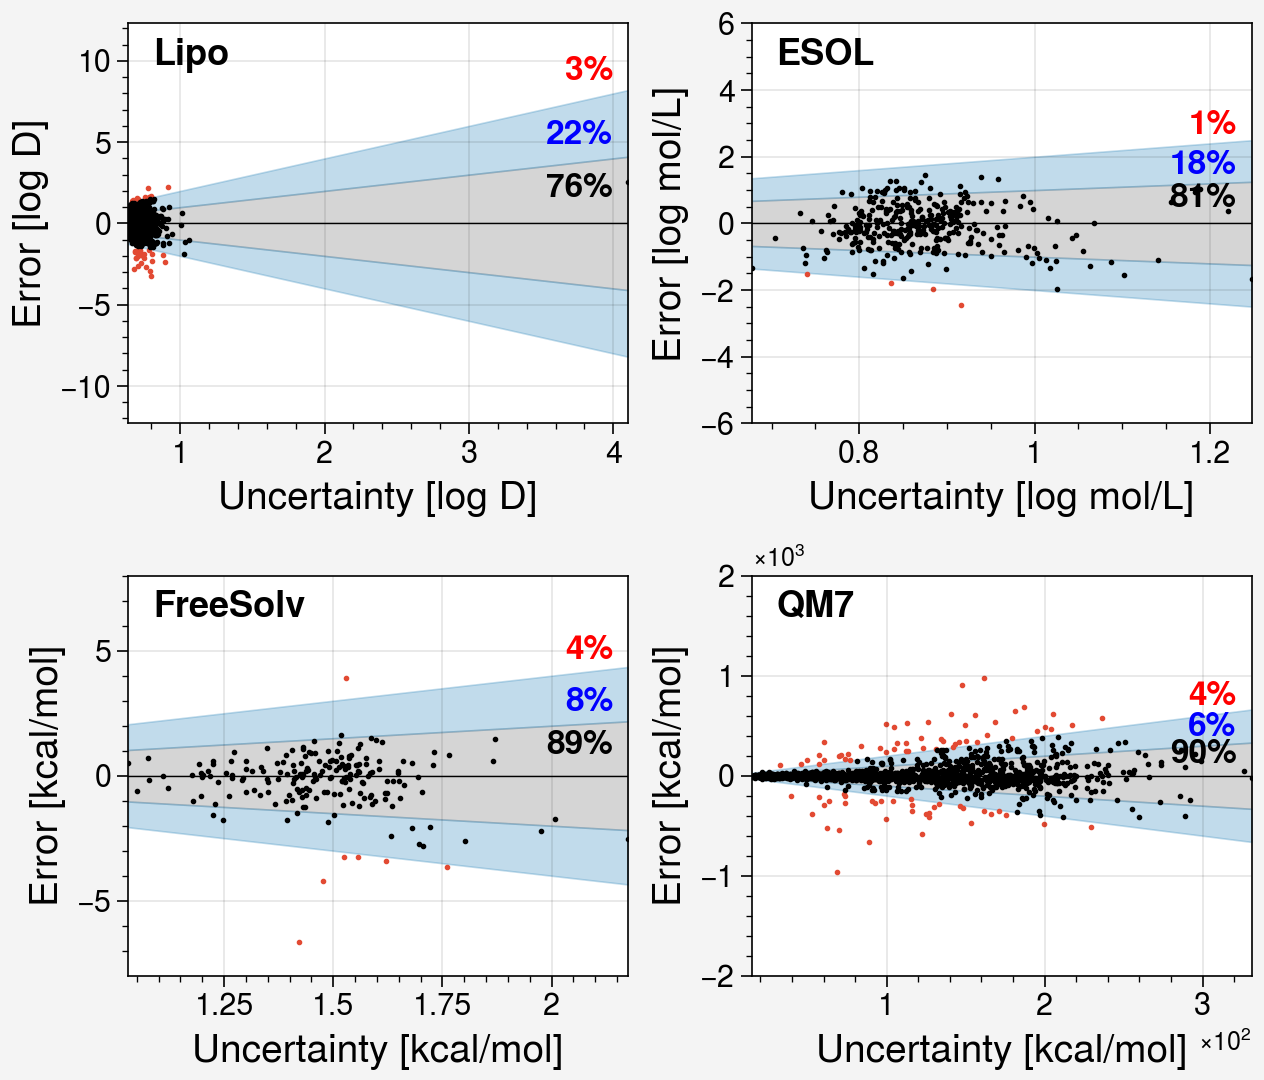

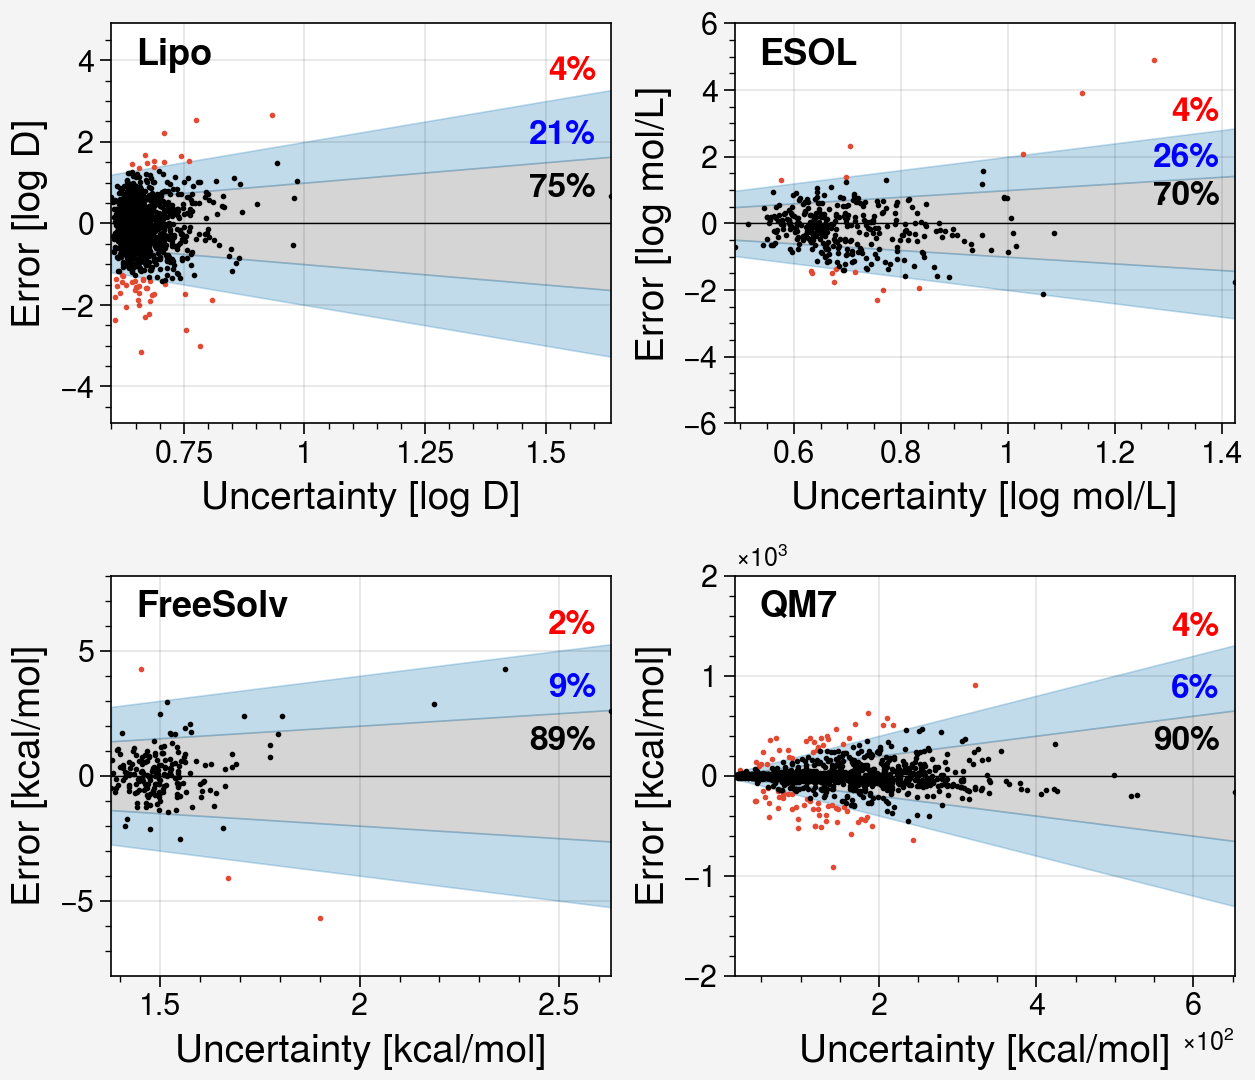

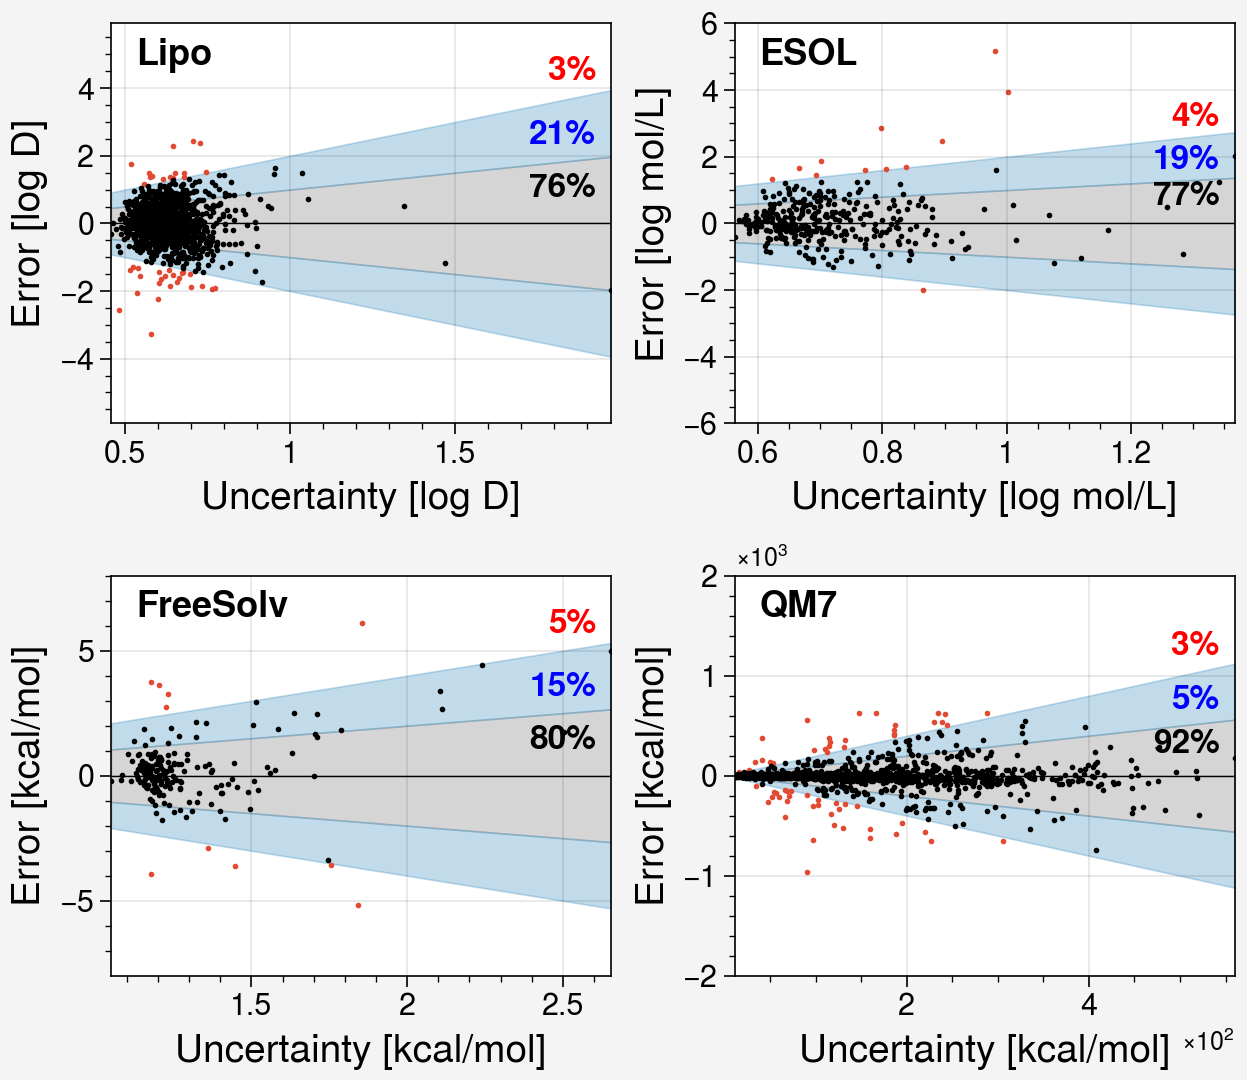

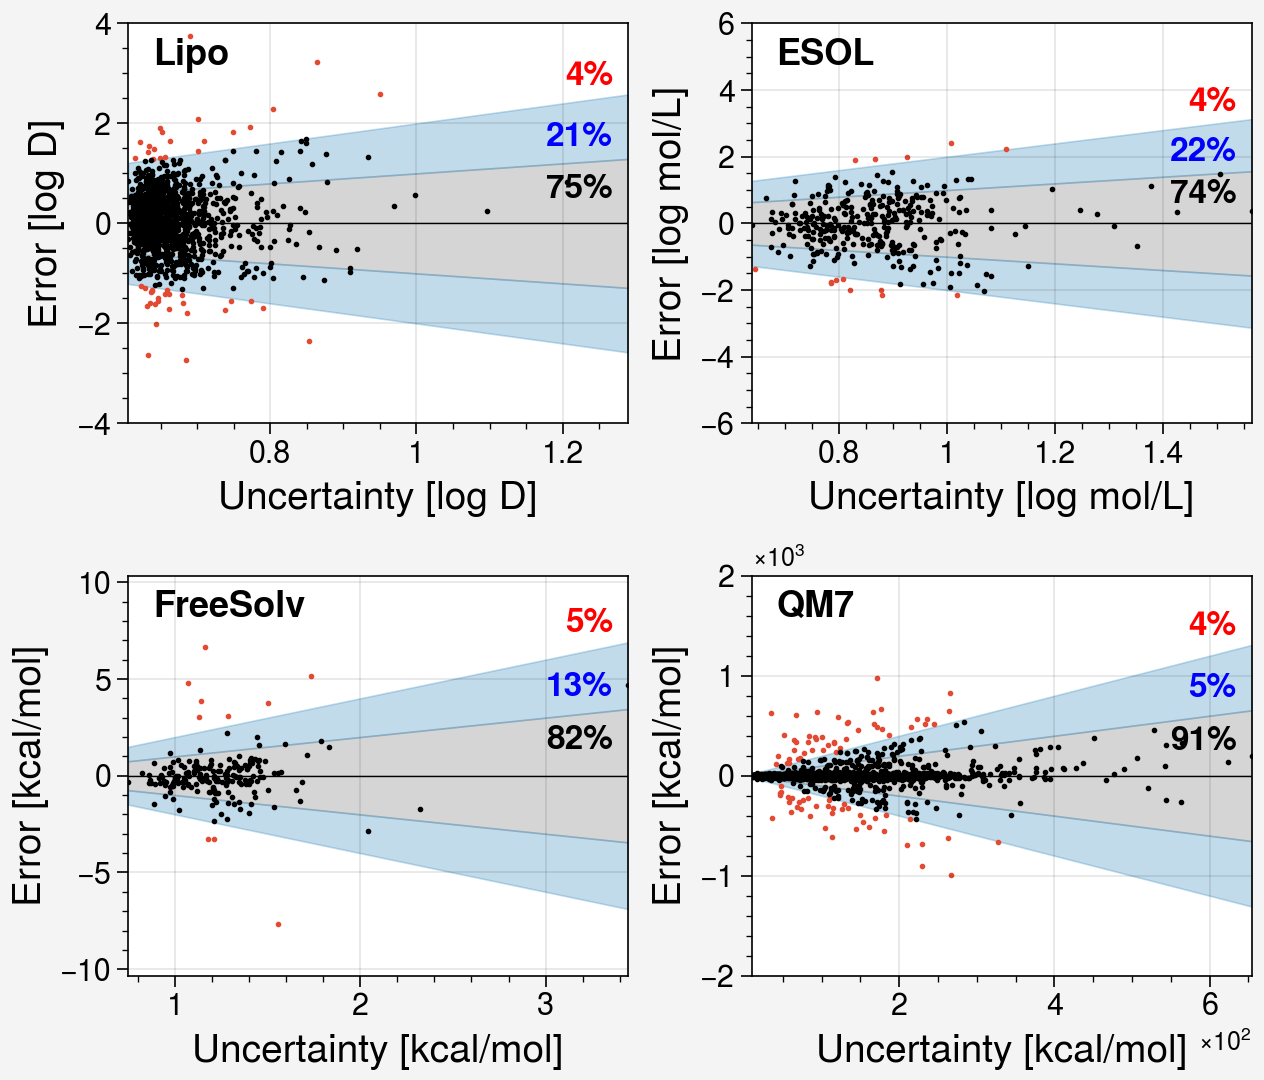

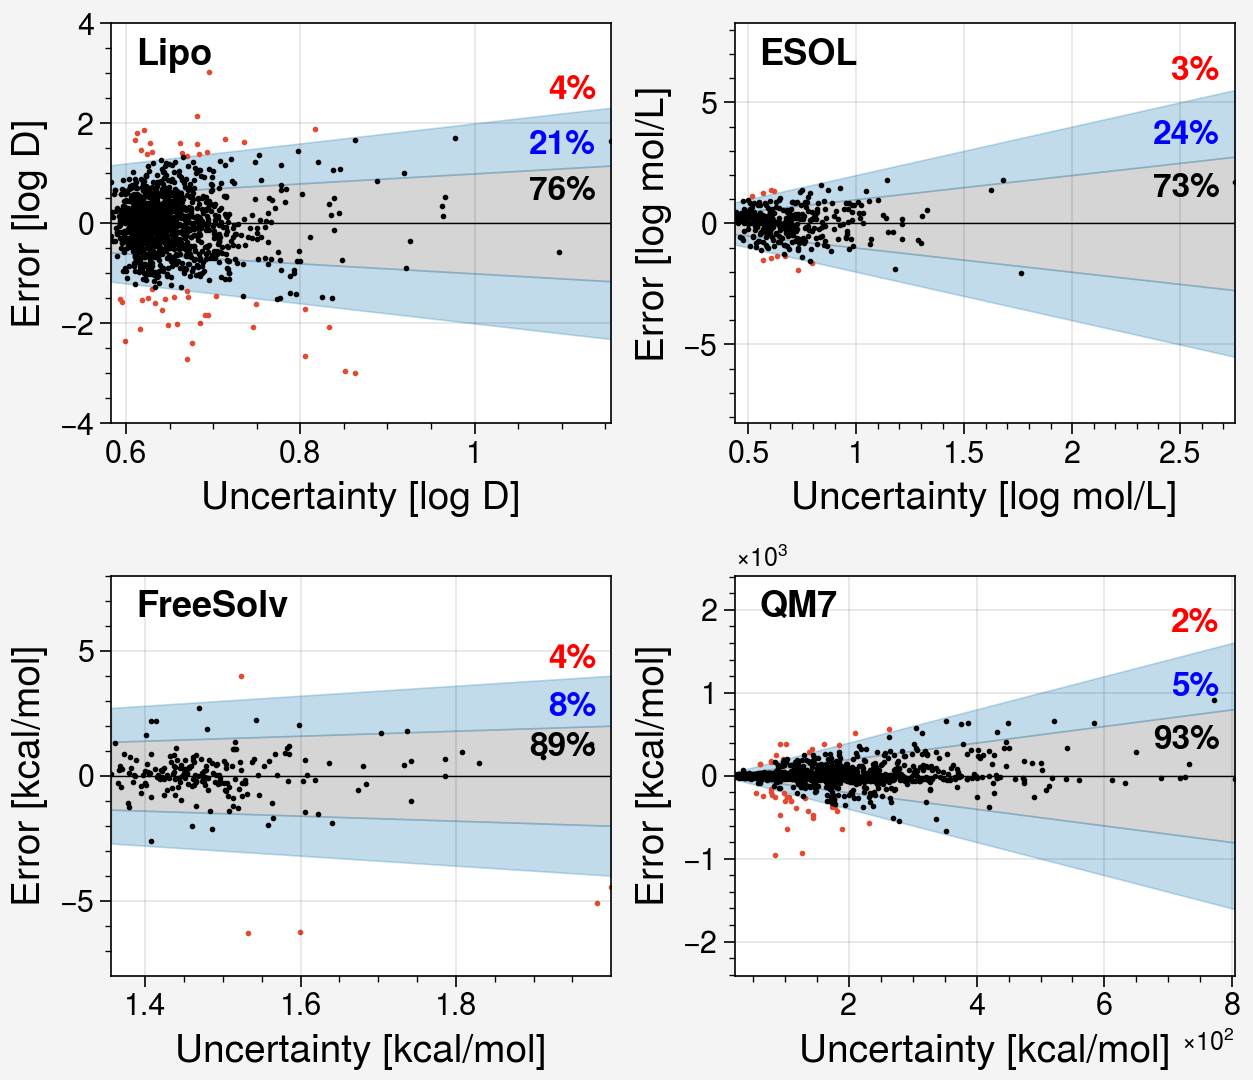

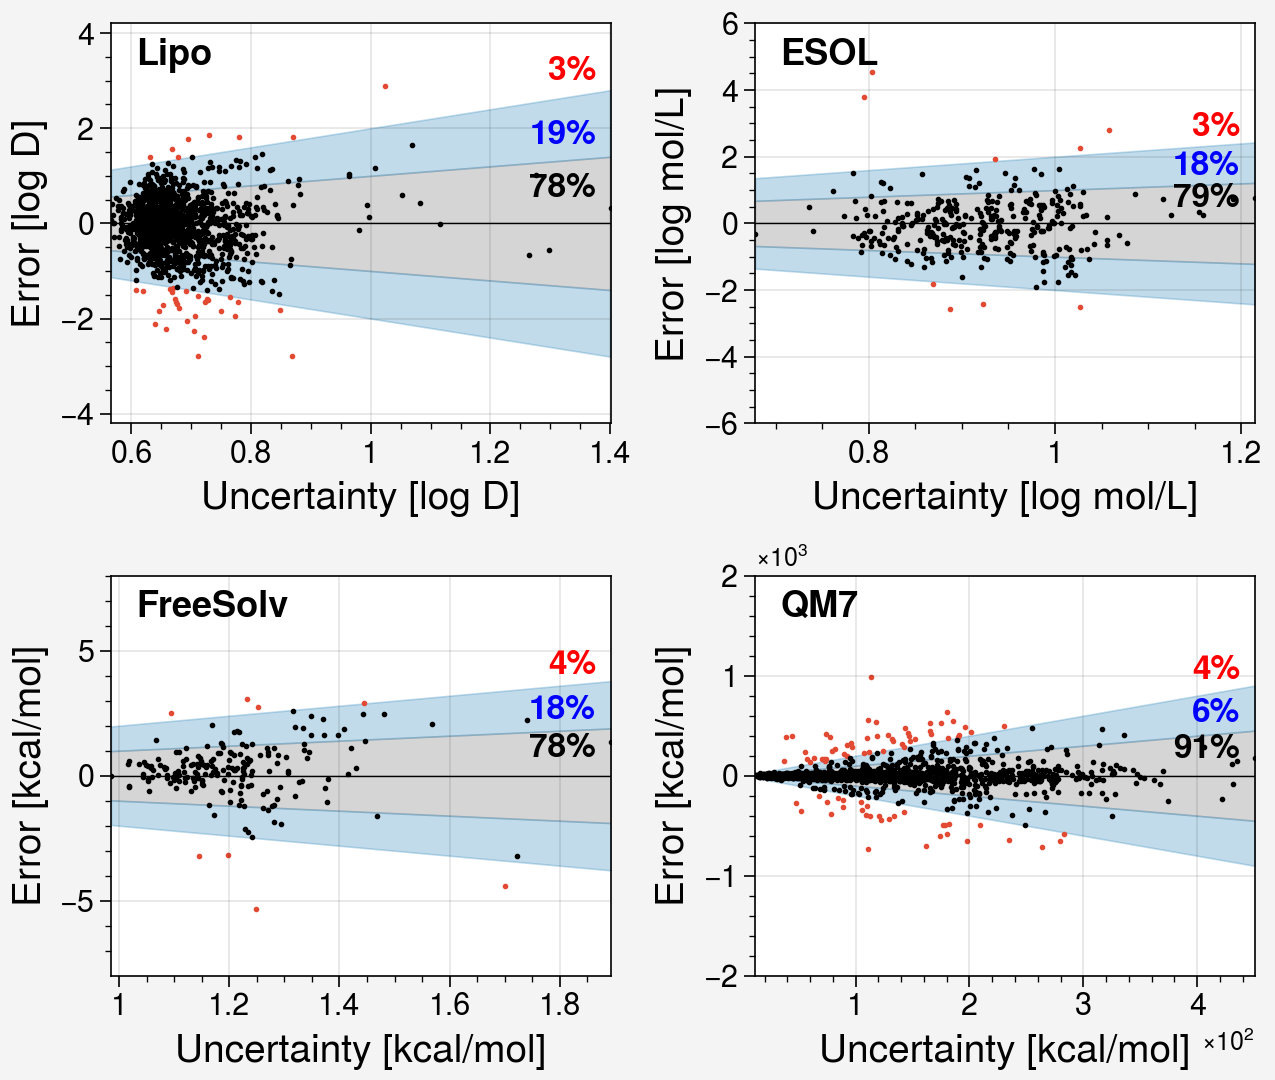

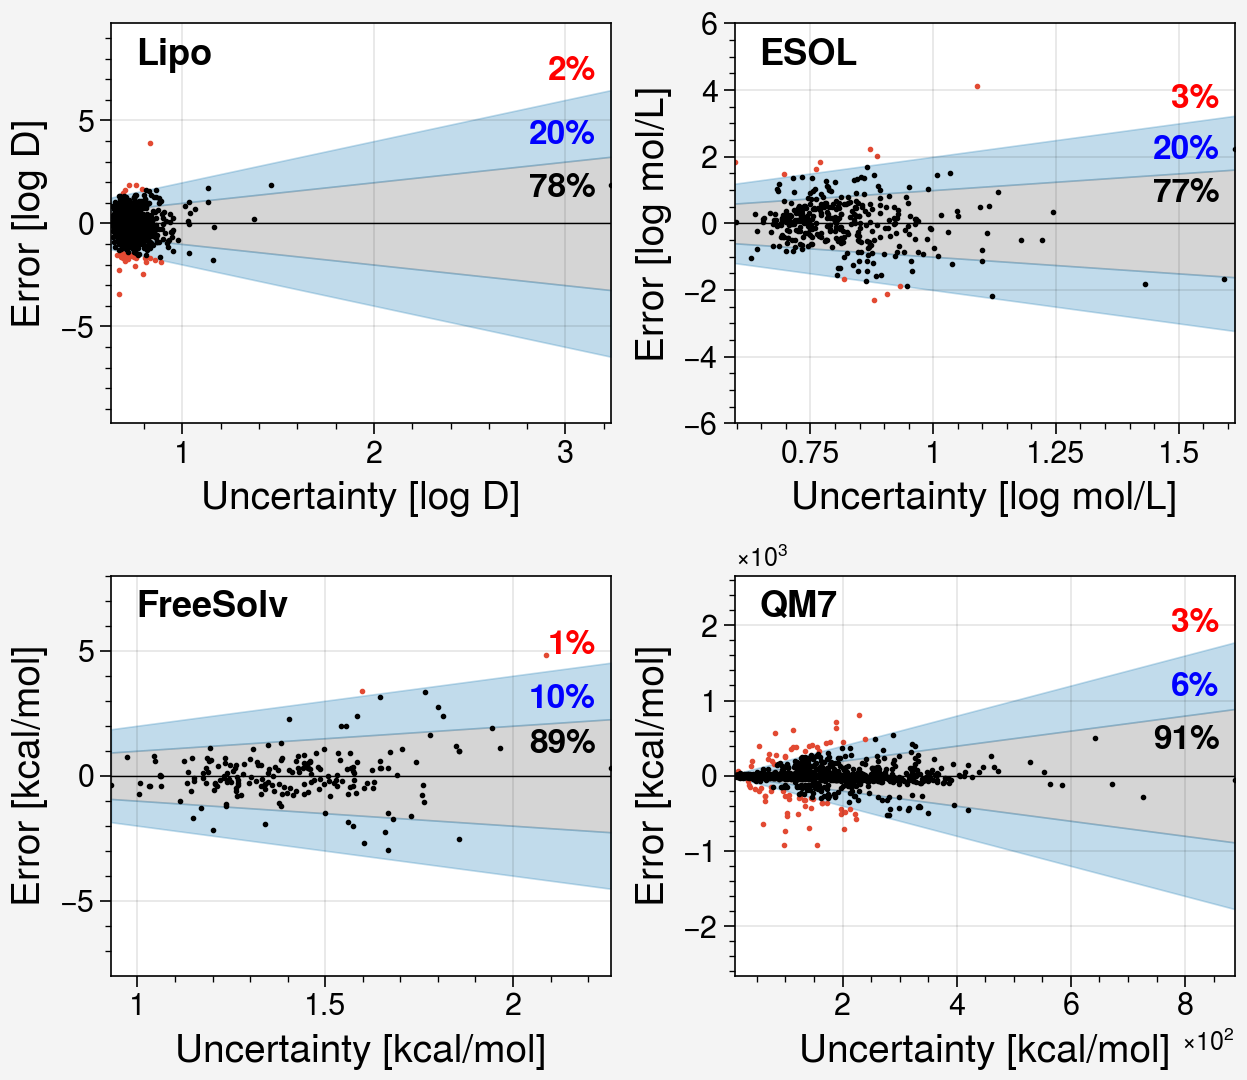

In [12]:
ratios = []
for seed in range(8):
    print(f"# seed {seed} uncertainty vs err ...")
    ratio = np.zeros((4, 3))
    fig, ax = pplt.subplots(refheight=2, refwidth=2.5, ncols=2, nrows=2, share=False)

    for i in range(4):
        dataset = NAME[i]

        if dataset == 'ESOL':
            dataset = 'delaney'

        y_true, y_pred, y_epis, y_alea, v_true, v_pred, v_epis, v_alea = result[(dataset.lower(), '523', seed)]

        std = (y_alea + y_epis) ** 0.5
        dif = y_true - y_pred

        vmin = std.min()
        vmax = std.max()
        xx = np.linspace(vmin, vmax, 100)

        emax = np.max(np.abs(dif))
        emax = np.max([vmax*3])


        ax[i].plot(xx, np.zeros_like(xx), 'k', lw=.5)
        ax[i].fill_between(xx, xx, -xx, alpha=0.3, color=COLOR[3])
        ax[i].fill_between(xx, 2*xx, xx, alpha=0.3, color=COLOR[1])
        ax[i].fill_between(xx, -2*xx, -xx, alpha=0.3, color=COLOR[1])

        idx1 = np.where(np.abs(dif) - 2*std >= 0)[0]
        idx2 = np.where(np.abs(dif) - 2*std < 0)[0]
        idx3 = np.where(np.abs(dif) - 1*std < 0)[0]

        ax[i].scatter(std[idx1], dif[idx1], color=COLOR[0], s=2)
        ax[i].scatter(std[idx2], dif[idx2], color='k', s=2, label=NAME[i])

        ax[i].text((vmax-vmin)*0.97+vmin, vmax*2.15, 
                   f'{len(idx1) / len(std) *100:0.0f}%', 
                   ha='right', fontsize=12, color='r', weight="bold")
        ax[i].text((vmax-vmin)*0.97+vmin, vmax*1.2, 
                   f'{(len(idx2)-len(idx3)) / len(std) *100:0.0f}%', 
                   ha='right', fontsize=12, color='blue', weight="bold")
        ax[i].text((vmax-vmin)*0.97+vmin, vmax*0.4, 
                   f'{(len(idx3)) / len(std) *100:0.0f}%', 
                   ha='right', fontsize=12, color='k', weight="bold")

    
        ratio[i, 0] = len(idx1) / len(std)
        ratio[i, 1] = (len(idx2) - len(idx3)) / len(std)
        ratio[i, 2] = (len(idx3)) / len(std)


        ax[i].text(0.05, 0.92, 
                   NAME[i], 
                   ha='left',
                   va='center',
                   transform=ax[i].transAxes,
                   fontsize=13, color='k', weight="bold")

        if i == 0:
            yticks = [-4, -2, 0, 2, 4]
        elif i == 1:
            yticks = [-6, -3, 0, 3, 6]
        elif i == 2:
            yticks = [-8, -4, 0, 4, 8]
        elif i == 3:
            yticks = [-2000, -1000, 0, 1000, 2000]

        emax = np.max([np.max(yticks), emax])


        ax[i].format(ylabel=f'Error [{UNIT[i]}]', 
                     xlabel=f'Uncertainty [{UNIT[i]}]', 
                     ylim=[-emax, emax],
                     xlabelsize=14, ylabelsize=14, 
                     xticklabelsize=11, yticklabelsize=11)


        if i == 3:
            ax[i].ticklabel_format(style='sci', axis='both', scilimits=(0,0))

    plt.savefig(f'../result/fig/err_std_{seed}.svg', bbox_inches='tight')
    
    ratios.append(ratio)
    
ratios = np.array(ratios)

print(ratios)

# Confidence-based Calibration

# Before recalibration
# ECE Lipo     0.05101 +/- 0.00915
# MCE Lipo     0.08868 +/- 0.01450
# MCA Lipo     0.05151 +/- 0.00925

# ECE delaney  0.05095 +/- 0.02162
# MCE delaney  0.09912 +/- 0.03087
# MCA delaney  0.05149 +/- 0.02183

# ECE FreeSolv 0.14972 +/- 0.03533
# MCE FreeSolv 0.26592 +/- 0.05647
# MCA FreeSolv 0.15122 +/- 0.03573

# ECE QM7      0.26484 +/- 0.02290
# MCE QM7      0.47680 +/- 0.04236
# MCA QM7      0.26755 +/- 0.02311



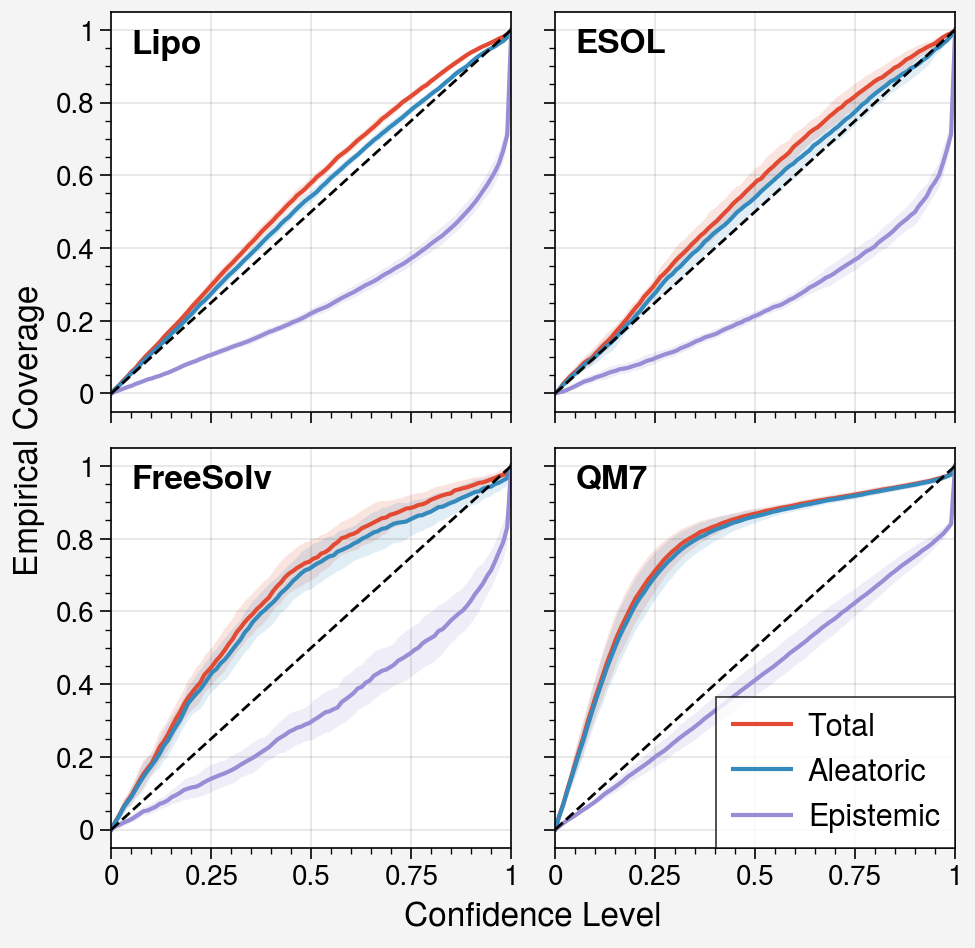

In [17]:
print(f"# Before recalibration")

fig, ax = pplt.subplots(refheight=2, refwidth=2, ncols=2, nrows=2)

for i in range(4):
    
    dataset = NAME[i]
    
    if dataset == 'ESOL':
        dataset = 'delaney'

    perc_tot = np.zeros((8, 100))
    perc_ale = np.zeros((8, 100))
    perc_epi = np.zeros((8, 100))
    MCA      = np.zeros((8, ))


    for seed in range(8):
        y_true, y_pred, y_epis, y_alea, v_true, v_pred, v_epis, v_alea = result[(dataset.lower(), '523', seed)]

        err = np.abs(y_true-y_pred)

        cf1, perc_tot[seed] = conf_level(y_true, y_pred, (y_alea+y_epis)**0.5)
        cf2, perc_ale[seed] = conf_level(y_true, y_pred, (y_alea)**0.5)
        cf3, perc_epi[seed] = conf_level(y_true, y_pred, (y_epis)**0.5)
        MCA[seed] = miscal_area((y_alea + y_epis), y_pred, y_true)[0]


    ax[i].plot(cf1, perc_tot.mean(axis=0), label="Total")
    ax[i].fill_between(cf1, 
                    perc_tot.mean(axis=0)-perc_tot.std(axis=0), 
                    perc_tot.mean(axis=0)+perc_tot.std(axis=0), alpha=0.15)

    ax[i].plot(cf2, perc_ale.mean(axis=0), label="Aleatoric")
    ax[i].fill_between(cf2, 
                    perc_ale.mean(axis=0)-perc_ale.std(axis=0), 
                    perc_ale.mean(axis=0)+perc_ale.std(axis=0), alpha=0.15)

    ax[i].plot(cf3, perc_epi.mean(axis=0), label="Epistemic")
    ax[i].fill_between(cf3, 
                    perc_epi.mean(axis=0)-perc_epi.std(axis=0), 
                    perc_epi.mean(axis=0)+perc_epi.std(axis=0),  alpha=0.15)
    
    ax[i].plot([0, 1], [0, 1], 'k--', lw=1)
        
    
    
    ax[i].text(0.05, 0.92, 
               NAME[i], 
               ha='left',
               va='center',
               transform=ax[i].transAxes,
               fontsize=12, color='k', weight="bold")

    ax[i].format(xlabel=r'Confidence Level', ylabel='Empirical Coverage',
              xlabelsize=12, ylabelsize=12, xticklabelsize=10, yticklabelsize=10)
    
    if i == 3:
        ax[i].legend(ncol=1, loc='lower right', prop={"size": 11})


    diff = np.abs(perc_tot - cf1)
    ece = np.mean(diff, axis=1)
    print(f"# ECE {dataset:<8} {ece.mean():<6.5f} +/- {ece.std():<6.5f}")

    mce = np.max(diff, axis=1)
    print(f"# MCE {dataset:<8} {mce.mean():<6.5f} +/- {mce.std():<6.5f}")
    print(f"# MCA {dataset:<8} {MCA.mean():<6.5f} +/- {MCA.std():<6.5f}")
    print()
    
plt.savefig('../result/fig/confidence_calib.svg', dpi=300, bbox_inches='tight')

# After recalibration
# ECE Lipo     0.01090 +/- 0.00495
# MCE Lipo     0.02822 +/- 0.00784
# MCA Lipo     0.01107 +/- 0.00495

# ECE delaney  0.02360 +/- 0.00813
# MCE delaney  0.05264 +/- 0.01436
# MCA delaney  0.02372 +/- 0.00816

# ECE FreeSolv 0.03657 +/- 0.01079
# MCE FreeSolv 0.09151 +/- 0.01838
# MCA FreeSolv 0.03669 +/- 0.01104

# ECE QM7      0.02843 +/- 0.00568
# MCE QM7      0.11747 +/- 0.01374
# MCA QM7      0.02873 +/- 0.00571



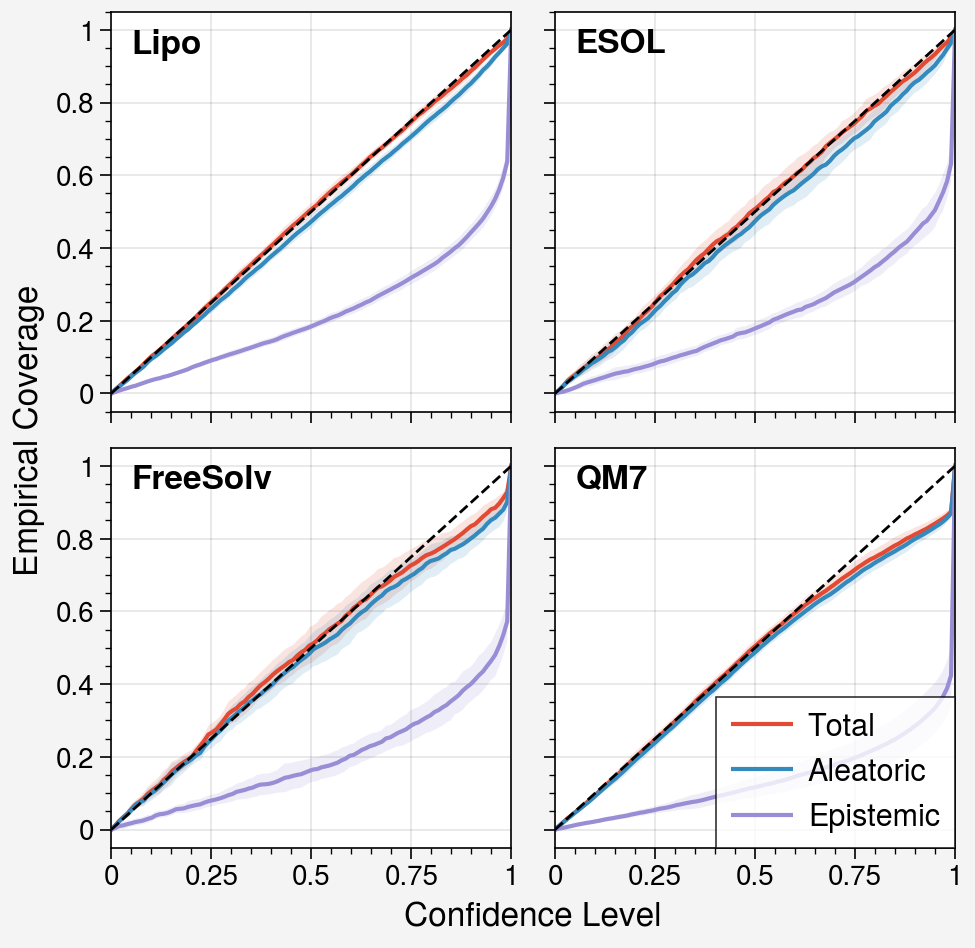

In [18]:
print(f"# After recalibration")

fig, ax = pplt.subplots(refheight=2, refwidth=2, ncols=2, nrows=2)

for i in range(4):
    
    dataset = NAME[i]
    
    if dataset == 'ESOL':
        dataset = 'delaney'

    perc_tot = np.zeros((8, 100))
    perc_ale = np.zeros((8, 100))
    perc_epi = np.zeros((8, 100))
    MCA      = np.zeros((8, ))


    for seed in range(8):
        y_true, y_pred, y_epis, y_alea, v_true, v_pred, v_epis, v_alea = result[(dataset.lower(), '523', seed)]

        err = np.abs(y_true-y_pred)
        
        
        
        a = uct.recalibration.optimize_recalibration_ratio(y_mean=v_pred, 
                                                           y_std=(v_alea+v_epis)**0.5,
                                                           y_true=v_true,
                                                           criterion='miscal')

        cf1, perc_tot[seed] = conf_level(y_true, y_pred, (a**2*y_alea+a**2*y_epis)**0.5)
        cf2, perc_ale[seed] = conf_level(y_true, y_pred, (a**2*y_alea)**0.5)
        cf3, perc_epi[seed] = conf_level(y_true, y_pred, (a**2*y_epis)**0.5)
        MCA[seed] = miscal_area((a**2*y_alea+a**2*y_epis), y_pred, y_true)[0]


    ax[i].plot(cf1, perc_tot.mean(axis=0), label="Total")
    ax[i].fill_between(cf1, 
                    perc_tot.mean(axis=0)-perc_tot.std(axis=0), 
                    perc_tot.mean(axis=0)+perc_tot.std(axis=0), alpha=0.15)

    ax[i].plot(cf2, perc_ale.mean(axis=0), label="Aleatoric")
    ax[i].fill_between(cf2, 
                    perc_ale.mean(axis=0)-perc_ale.std(axis=0), 
                    perc_ale.mean(axis=0)+perc_ale.std(axis=0), alpha=0.15)

    ax[i].plot(cf3, perc_epi.mean(axis=0), label="Epistemic")
    ax[i].fill_between(cf3, 
                    perc_epi.mean(axis=0)-perc_epi.std(axis=0), 
                    perc_epi.mean(axis=0)+perc_epi.std(axis=0),  alpha=0.15)
    
    ax[i].plot([0, 1], [0, 1], 'k--', lw=1)
        
    
    ax[i].text(0.05, 0.92, 
               NAME[i], 
               ha='left',
               va='center',
               transform=ax[i].transAxes,
               fontsize=12, color='k', weight="bold")

    ax[i].format(xlabel=r'Confidence Level', ylabel='Empirical Coverage',
              xlabelsize=12, ylabelsize=12, xticklabelsize=10, yticklabelsize=10)
    
    if i == 3:
        ax[i].legend(ncol=1, loc='lower right', prop={"size": 11})


    diff = np.abs(perc_tot - cf1)
    ece = np.mean(diff, axis=1)
    print(f"# ECE {dataset:<8} {ece.mean():<6.5f} +/- {ece.std():<6.5f}")

    mce = np.max(diff, axis=1)
    print(f"# MCE {dataset:<8} {mce.mean():<6.5f} +/- {mce.std():<6.5f}")
    print(f"# MCA {dataset:<8} {MCA.mean():<6.5f} +/- {MCA.std():<6.5f}")
    print()

plt.savefig('../result/fig/confidence_calib_recal.svg', dpi=300, bbox_inches='tight')

### Uncertainty decomposition

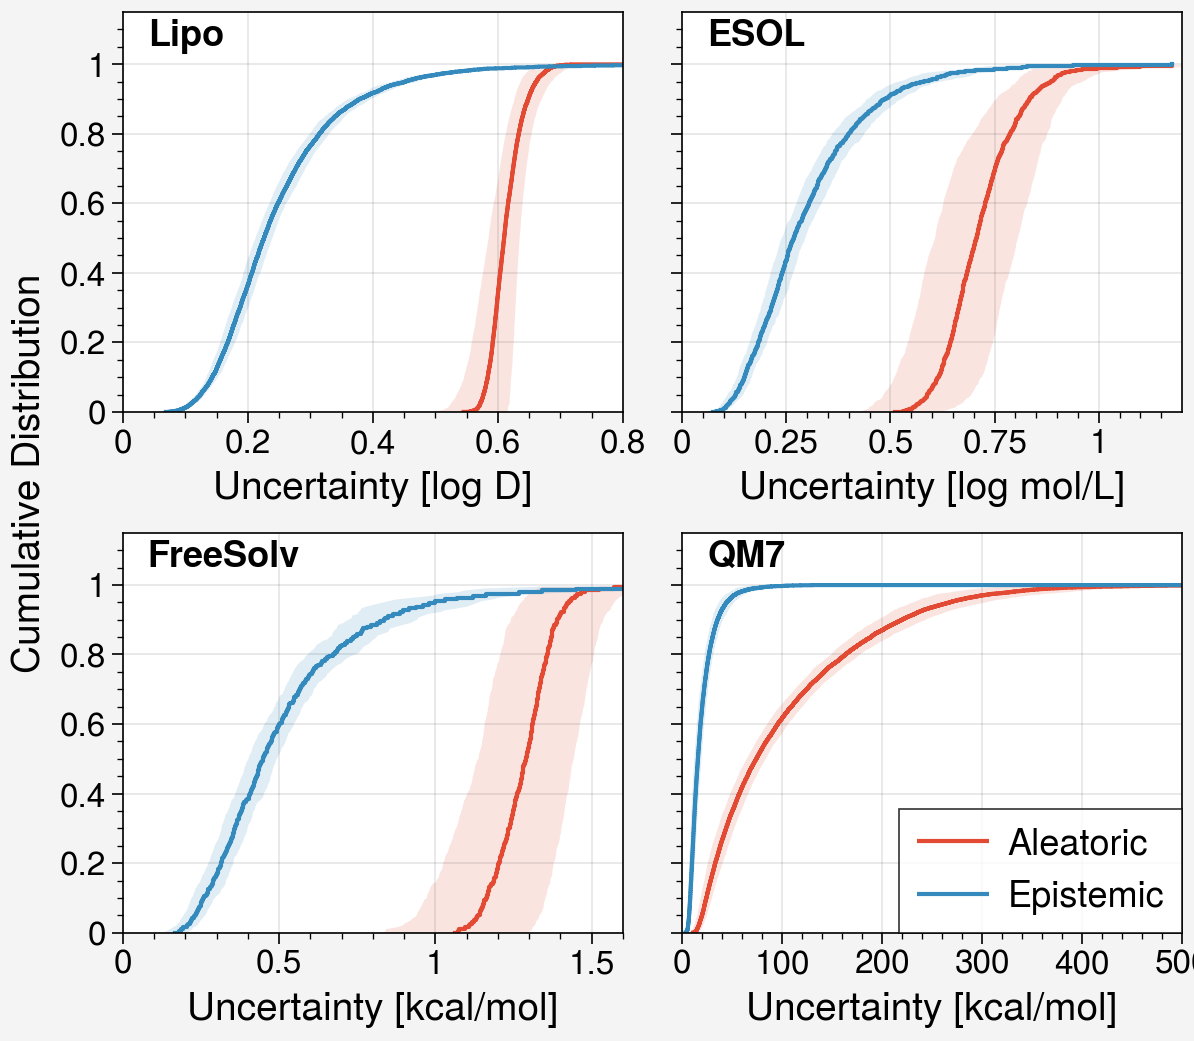

In [19]:
fig, ax = pplt.subplots(refheight=2, refwidth=2.5, ncols=2, nrows=2, sharex=False)

vmax = [0.8, 1.2, 1.6, 500]

for i in range(4):
    
    dataset = NAME[i]
    
    if dataset == 'ESOL':
        dataset = 'delaney'
        
    aleatoric_values = []
    epistemic_values = []

    for seed in range(8):
        y_true, y_pred, y_epis, y_alea, v_true, v_pred, v_epis, v_alea = result[(dataset.lower(), '523', seed)]
        
        aleatoric_values.append(y_alea**0.5)
        epistemic_values.append(y_epis**0.5)
        
    aleatoric_values = np.array(aleatoric_values)
    epistemic_values = np.array(epistemic_values)
    sorted_aleatoric_y = []
    
    for c in range(8):
        val = aleatoric_values[c]
        sort_indices = np.argsort(val)
        sorted_aleatoric_mean = val[sort_indices]
        cdf_values = np.linspace(0, 1, len(sorted_aleatoric_mean))
        sorted_aleatoric_y.append(sorted_aleatoric_mean)
        
    sorted_aleatoric_y = np.array(sorted_aleatoric_y)[:-1]
    sorted_aleatoric_mean = np.mean(sorted_aleatoric_y, axis=0)[:-1]
    sorted_aleatoric_std = np.std(sorted_aleatoric_y, axis=0)[:-1]

    lower_bound = sorted_aleatoric_mean - sorted_aleatoric_std
    upper_bound = sorted_aleatoric_mean + sorted_aleatoric_std
    
    sorted_epistemic_y = []
    for c in range(8):
        val = epistemic_values[c]
        sort_indices2 = np.argsort(val)
        sorted_epistemic_mean = val[sort_indices2]
        cdf_values2 = np.linspace(0, 1, len(sorted_epistemic_mean))
        sorted_epistemic_y.append(sorted_epistemic_mean)
        
    sorted_epistemic_y = np.array(sorted_epistemic_y)[:-1]
    sorted_epistemic_mean = np.mean(sorted_epistemic_y, axis=0)[:-1]
    sorted_epistemic_std = np.std(sorted_epistemic_y, axis=0)[:-1]
    
    lower_bound = sorted_aleatoric_mean - sorted_aleatoric_std
    upper_bound = sorted_aleatoric_mean + sorted_aleatoric_std
    lower_bound2 = sorted_epistemic_mean - sorted_epistemic_std
    upper_bound2 = sorted_epistemic_mean + sorted_epistemic_std

    if sorted_aleatoric_mean[-1] > sorted_epistemic_mean[-1]:
        sorted_epistemic_mean = np.append(sorted_epistemic_mean, sorted_aleatoric_mean[-1])
        cdf_values2 = np.append(cdf_values2, cdf_values[-1])
    else:
        sorted_aleatoric_mean = np.append(sorted_aleatoric_mean, sorted_epistemic_mean[-1])
        cdf_values = np.append(cdf_values, cdf_values2[-1])


    ax[i].plot(sorted_aleatoric_mean, cdf_values[:-1], drawstyle='steps-post', label='Aleatoric')
    ax[i].plot(sorted_epistemic_mean, cdf_values2[:-1], drawstyle='steps-post', label='Epistemic')
    ax[i].fill_betweenx(cdf_values[:len(lower_bound)], lower_bound, upper_bound, alpha=0.15)
    ax[i].fill_betweenx(cdf_values2[:len(lower_bound2)], lower_bound2, upper_bound2, alpha=0.15)
        
    
    ax[i].text(0.05, 0.94, 
               NAME[i], 
               ha='left',
               va='center',
               transform=ax[i].transAxes,
               fontsize=13, color='k', weight="bold")
    
    if i  == 0:
        xlabels = r'Uncertainty [log D]'
    elif i == 1:
        xlabels = r'Uncertainty [log mol/L]'
    elif i == 2:
        xlabels = r'Uncertainty [kcal/mol]'
    elif i == 3:
        xlabels = r'Uncertainty [kcal/mol]'
        

    ax[i].format(xlabel=xlabels, ylabel='Cumulative Distribution',
                 ylim=[0, 1.15], xlim=[0, vmax[i]],
              xlabelsize=14, ylabelsize=14, xticklabelsize=12, yticklabelsize=12)
    
    if i == 3:
        ax[i].legend(ncol=1, loc='lower right', prop={"size": 13})
    
plt.savefig('../result/fig/unc_decomposition.svg',  bbox_inches='tight')